# **Machine Learning for Neuroimaging 2023 — Assignment 3**

## **ABIDE I Functional Connectome Analysis**

You have been provided with a resting-state fMRI connectome dataset of 120 individuals diagnosed with Autism Spectrum Disorder (ASD) and 120 typical controls. Each connectome, i.e., each subject’s brain network and properties, is encoded as an 𝑁-by-𝑁 correlation matrix 𝐌, where $M_{i,j}$ is the functional connectivity (correlation in activation patterns) between region $i$ and region $j$.

Note that this is the preprocessed version of ABIDE provided by the Preprocessed Connectome Project (PCP).

For more information about this dataset's structure: http://preprocessed-connectomes-project.org/abide/

*Cameron Craddock, Yassine Benhajali, Carlton Chu, Francois Chouinard, Alan Evans, András Jakab, Budhachandra Singh Khundrakpam, John David Lewis, Qingyang Li, Michael Milham, Chaogan Yan, Pierre Bellec (2013). The Neuro Bureau Preprocessing Initiative: open sharing of preprocessed neuroimaging data and derivatives. In Neuroinformatics 2013, Stockholm, Sweden.*

**Relevant Libraries**
*  [NumPy](https://numpy.org/):https For numerical computing and handling multi-dimensional data.
*  [Pandas](https://pandas.pydata.org/): For structured data operations and manipulations.
*  [Matplotlib](https://matplotlib.org/): For creating static, interactive, and animated visualizations in Python.
*  [scikit-learn](https://scikit-learn.org/stable/): For implementing machine learning algorithms.
*  [nibabel](https://nipy.org/nibabel/): For reading and writing neuroimaging data formats.
*  [nilearn](https://nilearn.github.io/stable/index.html): For advanced neuroimaging data manipulation and visualization.
*  [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/): For writing and training Graph Neural Networks (GNNs).
*  [DGL (Deep Graph Library)](https://www.dgl.ai/): For deep learning on GNNs.

In [27]:
# %%capture
# # @title Run to install needed packages.
# !pip install nilearn torch torchvision torchaudio torch-geometric

In [28]:
# @title Load parcellated, connectivity matrices as our features, X
import numpy as np
import pickle as pkl
from nilearn.connectome import ConnectivityMeasure

'''
Load the connectivity matrices
Note: each connectivity matrix (sample) was derived using the NiftiLabelsMasker
and ConnectivityMeasure [with full Pearson's correlation] from nilearn and each
sample was also standardized by z-score
[i.e., zero mean scaled to unit variance w.r.t. sample std]
'''

data_path = './ABIDE_240.npz'
# Load the data
data = np.load(data_path)

# Accessing the arrays
connectomes = data['features']
y_abide = data['labels']
# print(f"y_abide: {y_abide}")

print("Data loaded from NPZ file.")

# Check the number of subject functional scans fetched
print(f"Number of subjects: {len(connectomes)}")

Data loaded from NPZ file.
Number of subjects: 240


In [29]:
from nilearn import plotting
from nilearn import datasets

# Retrieve AAL brain atlas for parcellation, more info here: https://www.sciencedirect.com/science/article/pii/S1053811901909784
parcellations = datasets.fetch_atlas_aal()
atlas_filename = parcellations.maps
labels = parcellations.labels
print(f"Number of ROIs: {len(labels)}")

# # Plot atlas
# plotting.plot_roi(atlas_filename, draw_cross=False)

Number of ROIs: 116


## Q1.

Plot a random connectivity matrix from the dataset.

---

In [30]:
cm_sample = connectomes[48]
# print(f"Connectivity matrix shape: {cm_sample.shape}")

# np.fill_diagonal(cm_sample, 0)

# plotting.plot_matrix(cm_sample, figure=(10, 8),
#                      labels=range(cm_sample.shape[-1]),
#                      vmax=0.8, vmin=-0.8, reorder=False)

The labels contain diagnostic group each participant is in. It is coded as:

*   1 = Autism Spectrum Disorder (ASD)
*   2 = Control

Let's re-index this to 0=ASD and 1=Control due to zero-indexed systems required for ML and other data processing software.

In [31]:
from collections import Counter

# Adjust labels to start from 0
y_abide = y_abide - 1

# Print label classes and counts
print(Counter(y_abide))

Counter({0: 120, 1: 120})


Now, you're ready to prepare the data for machine learning or statistical analysis.

Note: If you are interested in using graph neural networks, feel free to use the below PyG starter code to create your custom PyG (pytorch geometric) Dataset. Check the assignment description for links to related tutorials.

---

In [32]:
# import 
# @title [GraphML ONLY] Create custom PyG ConnectomeDataset
import torch
from torch_geometric.data import Data, Dataset
from torch_geometric.utils import dense_to_sparse

In [33]:
class ConnectomeDataset(Dataset):
    def __init__(self, connectivity_matrices, labels, task="classification", transform=None, pre_transform=None):
        super(ConnectomeDataset, self).__init__(None, transform, pre_transform)
        self.connectivity_matrices = connectivity_matrices
        self.labels = labels
        self.task = task

    def len(self):
        return len(self.connectivity_matrices)

    def get(self, idx):
        # Convert the connectivity matrix to edge index and edge attributes
        connectivity_matrix = torch.tensor(self.connectivity_matrices[idx])
        edge_index, edge_attr = dense_to_sparse(connectivity_matrix)

        # Create a data object
        data = Data(edge_index=edge_index, edge_attr=edge_attr)
        data.x = connectivity_matrix.to(torch.float)
        if self.task == "classification":
          data.y = torch.tensor([self.labels[idx]], dtype=torch.long) # make labels start at 0
        else:
          data.y = torch.tensor([self.labels[idx]], dtype=torch.float)
        return data

### Example - GraphML Classification

In [34]:
# import 
import torch
import torch_geometric.transforms as T
import torch.nn.functional as F

from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader

In [45]:
# Instantiate the dataset
# print(y_abide)
abide_dataset = ConnectomeDataset(connectomes, y_abide)
loader = DataLoader(abide_dataset, batch_size=32, shuffle=True)
# for i in loader:
#     print(i.y)

print(f'abide_dataset info:')
print(f'Number of graphs: {len(abide_dataset)}')
print("class (y_abide): ", np.unique(y_abide, return_counts=True))
print("Number of node features: ", abide_dataset.num_node_features)
print(f'Number of edge features: {abide_dataset.num_edge_features}')

num_classes = 2

# TO DO: Define a Graph Neural Network model
#...
# Define a GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(abide_dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        # Apply global mean pooling to get a single vector for the whole graph
        x = global_mean_pool(x, batch=data.batch)
        # x = F.log_softmax(x, dim=1)

        return x

abide_dataset info:
Number of graphs: 240
class (y_abide):  (array([0, 1], dtype=int64), array([120, 120], dtype=int64))
Number of node features:  116
Number of edge features: 1


In [46]:
# Initialize the model
GCN_model = GCN()
print(GCN_model)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GCN_model = GCN_model.to(device)

# Define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, GCN_model.parameters()),
            lr=0.01,
            weight_decay=0.0001
        )

GCN(
  (conv1): GCNConv(116, 16)
  (conv2): GCNConv(16, 2)
)


In [47]:
# Train the model
GCN_model.train()
loss_history =[]

for epoch in range(200):
    # Initialize variables to track the loss and accuracy for each epoch
    epoch_loss = 0.0
    epoch_correct_predictions = 0
    epoch_total_predictions = 0

    # Loop over each batch from the data loader
    # print(loader)
    for batch in loader:
        # Move batch to device
        batch = batch.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        out = GCN_model(batch)
        # Calculate loss
        # print(batch.y)
        loss = criterion(out, batch.y)
        epoch_loss += loss.item()
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Update the weights
        optimizer.step()
        # Calculate the number of correct predictions
        _, pred = torch.max(out, 1)
        epoch_correct_predictions += (pred == batch.y).sum().item()
        epoch_total_predictions += batch.y.size(0)

    # Calculate the average loss and accuracy for the epoch
    epoch_loss /= len(loader)
    loss_history.append(epoch_loss)
    epoch_accuracy = epoch_correct_predictions / epoch_total_predictions

    if epoch % 10 == 0: # Print every 10 epochs
        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.3f}, Accuracy: {epoch_accuracy:.3f}')



Epoch 1, Loss: 0.750, Accuracy: 0.479
Epoch 11, Loss: 0.689, Accuracy: 0.579
Epoch 21, Loss: 0.676, Accuracy: 0.583
Epoch 31, Loss: 0.672, Accuracy: 0.558
Epoch 41, Loss: 0.620, Accuracy: 0.650
Epoch 51, Loss: 0.564, Accuracy: 0.713
Epoch 61, Loss: 0.620, Accuracy: 0.617
Epoch 71, Loss: 0.567, Accuracy: 0.700
Epoch 81, Loss: 0.532, Accuracy: 0.725
Epoch 91, Loss: 0.532, Accuracy: 0.713
Epoch 101, Loss: 0.549, Accuracy: 0.717
Epoch 111, Loss: 0.520, Accuracy: 0.708
Epoch 121, Loss: 0.517, Accuracy: 0.717
Epoch 131, Loss: 0.543, Accuracy: 0.704
Epoch 141, Loss: 0.619, Accuracy: 0.696
Epoch 151, Loss: 0.472, Accuracy: 0.771
Epoch 161, Loss: 0.489, Accuracy: 0.746
Epoch 171, Loss: 0.471, Accuracy: 0.754
Epoch 181, Loss: 0.471, Accuracy: 0.762
Epoch 191, Loss: 0.501, Accuracy: 0.758


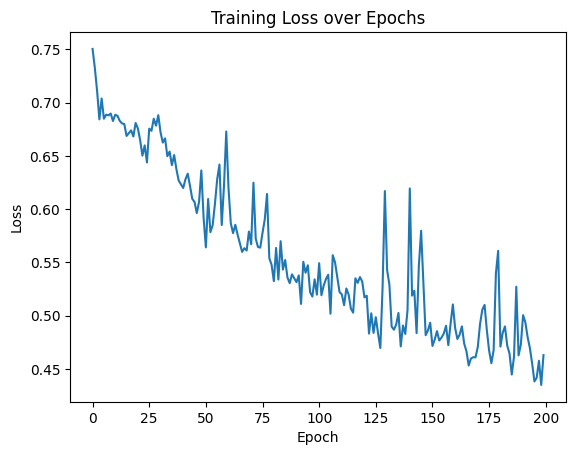

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import nilearn
from nilearn import plotting
from nilearn import datasets

# Plot training loss history over epochs
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

## Q2.

### Example - Graph Network Metrics

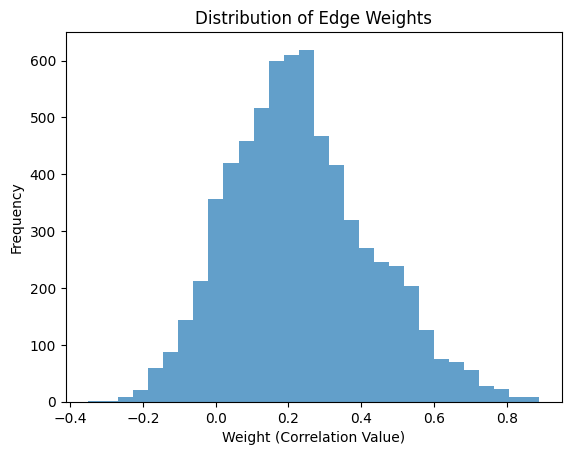

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# 'cm_sample' is a random connectome from our dataset
weights = cm_sample[np.triu_indices_from(cm_sample, k=1)]  # Extract upper triangle to avoid duplication

# Plotting the distribution of weights
plt.hist(weights, bins=30, alpha=0.7)
plt.title("Distribution of Edge Weights")
plt.xlabel("Weight (Correlation Value)")
plt.ylabel("Frequency")
plt.show()


### Example - Network Community Detection

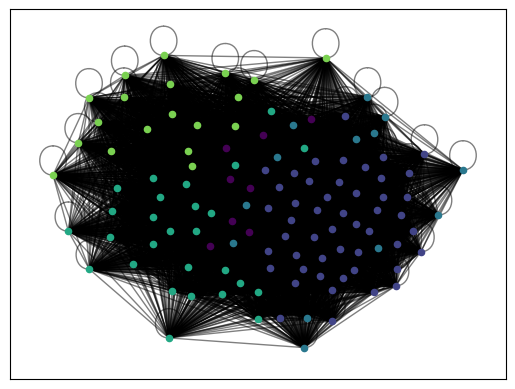

In [40]:
import networkx as nx
import numpy as np
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt

from matplotlib import colormaps

'''Note: networkx expects non-negative edge weights for community detection;
convert connectome edge weights to absolute value (changes edge weight
information to strength only and not whether positively or negatively
correlated.)
'''
# Find the absolute maximum value in the connectome for scaling
abs_cm_sample = np.abs(cm_sample)

G = nx.from_numpy_array(abs_cm_sample)

# Use the Louvain method for community detection
partition = community_louvain.best_partition(G, weight='weight')

# Visualize the communities
pos = nx.spring_layout(G)  # Positioning of the nodes
cmap = colormaps['viridis']

for com in set(partition.values()):
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size=20,
                           node_color=[cmap(com / (max(partition.values()) + 1))])

nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()


In [49]:
# # Initialize the model
# GCN_model = GCN()
# print(GCN_model)

# # Move to GPU if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# GCN_model = GCN_model.to(device)
# data = dataset[0].to(device)

# # Define loss and optimizer
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(GCN_model.parameters(), lr=0.01)
